# MCT4001 Scientific Computing in Python Session 8
![mct-banner](https://raw.githubusercontent.com/wiki/MCT-master/Guides/assets/img/mct-banner.jpg)

In [1]:
# importing packages

import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import sounddevice as sd
import librosa
import librosa.display
import math
import scipy
import time

#importing signal processing package from scipy (if not we have to specify scipy.signal)
from scipy import signal


# defining funtions that will be used in this notebook

def mySineSynth(freq, dur_ms, amp=1, pha=0, sr=48000):

    t = np.arange(0,dur_ms/1000,1/sr)
    s = amp*np.sin(2*np.pi*freq*t+pha)
    
    return s

def myPlotStem(signal,title):
    plt.figure(figsize=(10, 3))
    plt.stem(signal, use_line_collection=True)
    plt.grid(True)
    plt.xticks(range(0,signal.size))
    plt.ylim([-1,1])
    plt.title(title)
    plt.show()

def myPlotLine(signal,title):
    plt.figure(figsize=(10, 3))
    plt.plot(signal)
    plt.grid(True)
    plt.ylim([-1,1])
    plt.title(title)
    plt.show()
    
def mySpectrogram(s,sr,title):
    D = librosa.stft(s)
    DdB = librosa.amplitude_to_db(abs(D))
    plt.figure(figsize=(10, 3))
    librosa.display.specshow(DdB, sr=sr, x_axis='time', y_axis='hz')
    plt.title(title)
    plt.show()

def myWaveform(s,sr,title):
    plt.figure(figsize=(10, 3))
    librosa.display.waveplot(s, sr=sr)
    plt.title(title)
    plt.show()

def myFiltResponse(b,a,sr):
    w, h = scipy.signal.freqz(b,a)
    fig, ax1 = plt.subplots()
    ax1.set_title('Digital filter frequency response')
    ax1.plot(w/math.pi, 20 * np.log10(abs(h)), 'b')
    ax1.set_ylabel('Amplitude [dB]', color='b')
    ax1.set_xlabel('Normalized Frequency')
    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    ax2.plot(w/math.pi, angles, 'g')
    ax2.set_ylabel('Angle (radians)', color='g')
    ax2.grid()
    ax2.axis('tight')
    plt.show()


In [2]:
%config IPCompleter.greedy=True
%matplotlib inline

## Filter Design & Filtering Fucntions

In Scipy there is a rich collection of functions for [signal processing](https://docs.scipy.org/doc/scipy/reference/signal.html), including functions for **[Filtering](https://docs.scipy.org/doc/scipy/reference/signal.html#filtering)** and for **[Filter Design](https://docs.scipy.org/doc/scipy/reference/signal.html#filter-design)**. 

With **Filtering** we refer to the process of obtaining the filtered signal given the input signal and the filter coefficients.

With **Filter Design** we refer to the process of obtaining filter coefficients (*b* only for FIR - only numerator, *b* and *a* for IIR - both numerator and denominator coefficients) given fucntional parameters of the filters (such as the desired response in the frequency domain).

Generally we have to design a filter before being able to use it (filtering) one or multiple times.

Among available functions to design FIR filters there are:
* [firwin](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.firwin.html#scipy.signal.firwin)
* [firwin2](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.firwin2.html#scipy.signal.firwin2)

Among available functions to design IIR filters there is:
* [iirdesign](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.iirdesign.html#scipy.signal.iirdesign)
* [MATLAB-style functions](https://docs.scipy.org/doc/scipy/reference/signal.html#matlab-style-iir-filter-design)

To filter a signal with a FIR or IIR, we can simply pass the filter coefficients to the function [lfilter](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lfilter.html#scipy.signal.lfilter). To compute the frequency response (already included in the myIIRResponse function) we can use the function [freqz](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.freqz.html#scipy.signal.freqz). 


In [3]:
#defining global sampling rate
sr = 48000


### 1. FIR

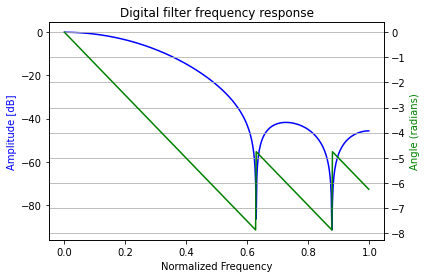

In [4]:
# designing low pass FIR filter with firwin

numtaps = 9 #filter lenght

f = 0.2 #cutoff normalized frequency, must between 0 and fs/2 (if not specified fs=2)

b = signal.firwin(numtaps, f, pass_zero=True)

# displaying response
myFiltResponse(b,1,sr)


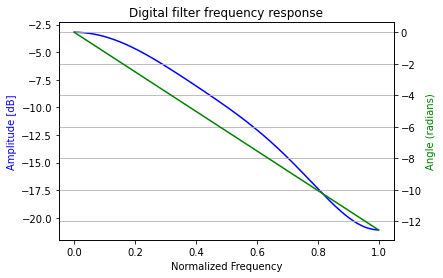

In [5]:
# designing low pass FIR filter with firwin2

numtaps = 9 #filter lenght

freqs = [0.0, 0.2, 1.0] #list of normalized frequency values (between 0 and 1, unless fs is specified)
                        # must start with 0 and finish with 2 (or fs/2 if fs specified)

gains = [1.0, 0.5, 0.0] #list of corresponding gain values (between 0 and 1)


b = signal.firwin2(numtaps, freqs, gains)

# displaying response
myFiltResponse(b,1,sr)

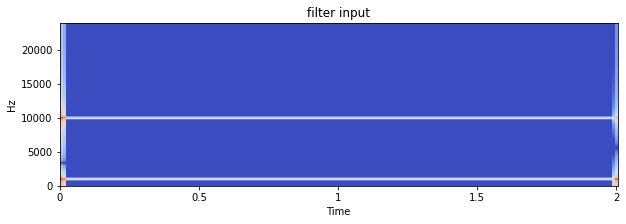

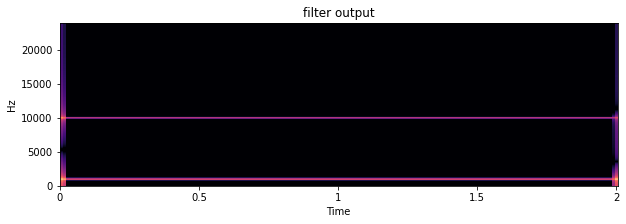

In [6]:
# testing the filter with a signal with two components

x = mySineSynth(freq=1000, dur_ms=2000, amp=0.5, pha=0, sr=sr) + \
     + mySineSynth(freq=10000, dur_ms=2000, amp=0.5, pha=0, sr=sr)


#alternatively we can try with white gaussina noise
#x = np.random.normal(0, 0.1, 2*sr)

# computing the output (this can be done also via convolution, is the same operation for a FIR)
y = signal.filtfilt(b, 1, x)

#displaying results
mySpectrogram(x, sr, 'filter input')
mySpectrogram(y, sr, 'filter output')

#myWaveform(x, sr, 'filter input')
#myWaveform(y, sr, 'filter output')


In [7]:
sd.play(x,sr)
sd.wait()
sd.play(y,sr)
sd.wait()

### 2. IIR

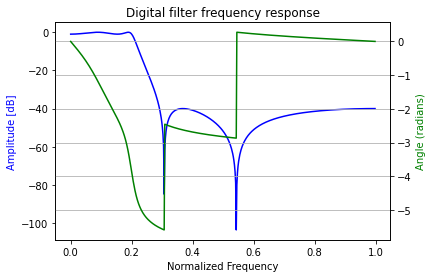

In [8]:
# designing low pass IIR filter with iirdesign (we cannot specify the order)

wp = 0.2 # passband edge frequency
ws = 0.3 # stopband edge frewuency
gpass = 1 # maximum loss in the passband (dB).
gstop = 40 # minimum attenuation in the stopband (dB).

[b,a] = signal.iirdesign(wp, ws, gpass, gstop)

# displaying response
myFiltResponse(b,a,sr)

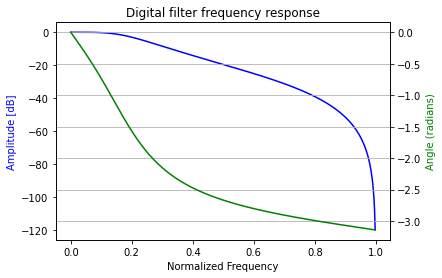

In [9]:
# designing low pass IIR filter with one of the MATLAB-style functions (we can specify the order)

order = 2
fc = 0.2 # cutoff normalized frequency

b,a = signal.butter(order, fc, 'low', analog=False)

# displaying response
myFiltResponse(b,a,sr)

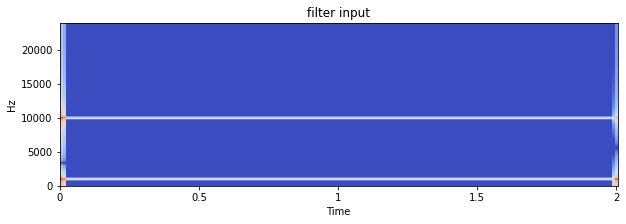

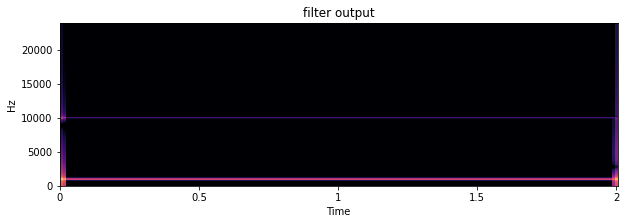

In [10]:
# testing the filter with a signal with two components

x = mySineSynth(freq=1000, dur_ms=2000, amp=0.5, pha=0, sr=sr) + \
     + mySineSynth(freq=10000, dur_ms=2000, amp=0.5, pha=0, sr=sr)


#alternatively we can try with white gaussina noise
#x = np.random.normal(0, 0.1, 2*sr)

# computing the output
y = signal.filtfilt(b, a, x)

#displaying results
mySpectrogram(x, sr, 'filter input')
mySpectrogram(y, sr, 'filter output')

#myWaveform(x, sr, 'filter input')
#myWaveform(y, sr, 'filter output')


In [11]:
sd.play(x,sr)
sd.wait()
sd.play(y,sr)
sd.wait()


## 2. Phase Considerations

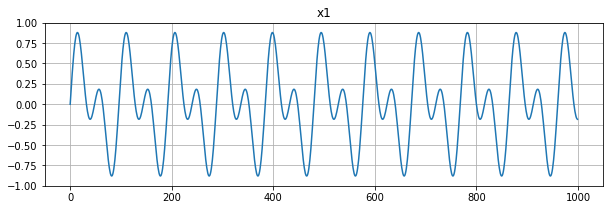

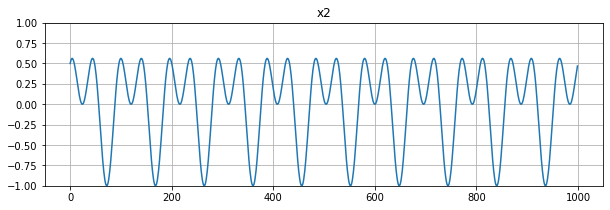

In [12]:
# showing two signals with identical frequency components but different phase
# waveforms look different, signals sound identical (our ears are "phase deaf")

sr = 48000

x1 = mySineSynth(freq=500, dur_ms=2000, amp=0.5, pha=0, sr=sr) + \
     + mySineSynth(freq=1000, dur_ms=2000, amp=0.5, pha=0, sr=sr)

x2 = mySineSynth(freq=500, dur_ms=2000, amp=0.5, pha=0, sr=sr) + \
     + mySineSynth(freq=1000, dur_ms=2000, amp=0.5, pha=math.pi/2, sr=sr)

# plotting only the first 1000 samples to show the difference  in the waveform
myPlotLine(x1[0:1000],'x1')
myPlotLine(x2[0:1000],'x2')


In [13]:
sd.play(x1,sr)
sd.wait()
sd.play(x2,sr)
sd.wait()


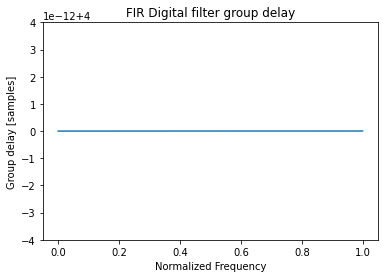

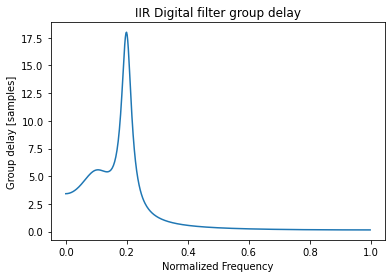

In [14]:
# FIR  vs IIR group delay

b = signal.firwin2(9, [0.0, 0.2, 1.0], [1.0, 0.5, 0.0])

w, gd = signal.group_delay((b, 1))
plt.title('FIR Digital filter group delay')
plt.plot(w/math.pi, gd)
plt.ylabel('Group delay [samples]')
plt.xlabel('Normalized Frequency')
plt.show()


[b,a] = signal.iirdesign(0.2, 0.3, 1, 40)

w, gd = signal.group_delay((b, a))
plt.title('IIR Digital filter group delay')
plt.plot(w/math.pi, gd)
plt.ylabel('Group delay [samples]')
plt.xlabel('Normalized Frequency')
plt.show()